In [ ]:
### Han Gong
### Assignment Blog: https://hannah-gong.github.io/biostat823-hw-projects-website/
### Repo: https://github.com/Hannah-GOng/biostat823-hw-projects-website

In [3]:
# locate drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pwd
import os
os.chdir('/content/drive/MyDrive/BIOSTAT823/HW5')
!pwd

/content
/content/drive/MyDrive/BIOSTAT823/HW5


In [5]:
# import necessary dependencies
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# data preprocessing
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.CenterCrop(256),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.CenterCrop(256),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [7]:
from torch.utils.data import DataLoader, random_split

DATA_ROOT = "./insects"
BATCH_SIZE = 32

# construct dataset
train_set = datasets.ImageFolder(
    DATA_ROOT + '/train', 
    transform = transform_train)

train_set, val_set = random_split(train_set, [800, 219])

test_set = datasets.ImageFolder(
    DATA_ROOT + '/test', 
    transform = transform_test)


# construct data loader
train_loader = DataLoader(
    train_set, 
    batch_size= BATCH_SIZE,
    shuffle= True,
    num_workers=2
)

val_loader = DataLoader(
    val_set, 
    batch_size= BATCH_SIZE,
    shuffle= True,
    num_workers=2
)

test_loader = DataLoader(
    test_set, 
    batch_size= BATCH_SIZE,
    shuffle= True,
    num_workers=2
)

# labels
classes = ('dragonfly', 'cockroach', 'beetle')

torch.Size([32, 3, 256, 256])


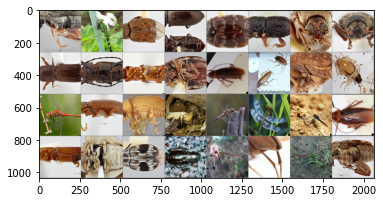

dragonfly beetle dragonfly dragonfly dragonfly dragonfly dragonfly dragonfly dragonfly dragonfly dragonfly dragonfly cockroach cockroach dragonfly cockroach beetle dragonfly dragonfly cockroach beetle beetle beetle cockroach dragonfly dragonfly dragonfly cockroach beetle dragonfly beetle dragonfly


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [9]:
# define the SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(61504, 1024)
        self.fc2   = nn.Linear(1024, 64)
        self.fc3   = nn.Linear(64, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [10]:
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Initialize Model
net = SimpleNN()
net.to(device)

Run on CPU...


SimpleNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=61504, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
import torch.nn as nn
import torch.optim as optim

INITIAL_LR = 0.001

# momentum for optimizer
MOMENTUM = 0.9

# regularization strength
REG = 1e-4

# Add optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), momentum=MOMENTUM, lr = INITIAL_LR, weight_decay = REG)

In [12]:
import time as timer

EPOCHS = 20
DECAY_EPOCHS = 10
DECAY = 1.0

# the folder where the trained model is saved
CHECKPOINT_PATH = "./saved_model"


best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    net.train() 
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0 
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # copy inputs to device
        x, y = inputs.to(device), targets.to(device)
        
        # compute the output and loss
        y_pred = net(x)
        _, labels = torch.max(y_pred, 1)
        loss = criterion(y_pred, y)
        train_loss += loss
        
        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()
        
        # apply gradient and update the weights
        optimizer.step()
        
        # count the number of correctly predicted samples in the current batch
        correct_examples += (labels == y).float().sum()
        total_examples += len(inputs)
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    train_acc_list.append(avg_acc)
    train_loss_list.append(avg_loss)

    # switch to eval mode
    net.eval()
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            # copy inputs to device
            x, y = inputs.to(device), targets.to(device)
            
            # compute the output and loss
            y_pred = net(x)
            _, labels = torch.max(y_pred, 1)  
            loss = criterion(y_pred, y)
            val_loss += loss
                      
            # count the number of correctly predicted samples in the current batch
            correct_examples += (labels == y).float().sum()
            total_examples += len(inputs)

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    val_acc_list.append(avg_acc)
    val_loss_list.append(avg_loss)
    
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'simplenn.pth'))
        
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 2.1387, Training accuracy: 0.1850
Validation loss: 1.6912, Validation accuracy: 0.3379
Saving ...

Epoch 1:
Training loss: 1.1555, Training accuracy: 0.5163
Validation loss: 0.9392, Validation accuracy: 0.4749
Saving ...

Epoch 2:
Training loss: 0.8439, Training accuracy: 0.6350
Validation loss: 0.7738, Validation accuracy: 0.6164
Saving ...

Epoch 3:
Training loss: 0.7243, Training accuracy: 0.6888
Validation loss: 0.7695, Validation accuracy: 0.7032
Saving ...

Epoch 4:
Training loss: 0.6567, Training accuracy: 0.7362
Validation loss: 0.7117, Validation accuracy: 0.6667

Epoch 5:
Training loss: 0.6267, Training accuracy: 0.7487
Validation loss: 0.6784, Validation accuracy: 0.6986

Epoch 6:
Training loss: 0.5902, Training accuracy: 0.7638
Validation loss: 0.7700, Validation accuracy: 0.7078
Saving ...

Epoch 7:
Training loss: 0.5550, Training accuracy: 0.7763
Validation loss: 0.8208, Validation accuracy: 0.6621

Epoch 8:
Training loss: 0.50

(0.0, 20.0)

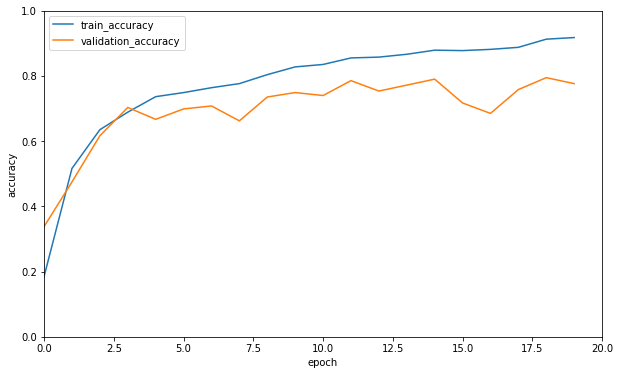

In [16]:
# PLOT Accuracy
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_acc_list, label='train_accuracy')
ax.plot(val_acc_list, label='validation_accuracy')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
plt.ylim([0, 1])
plt.xlim([0, 20])

(0.0, 1.0)

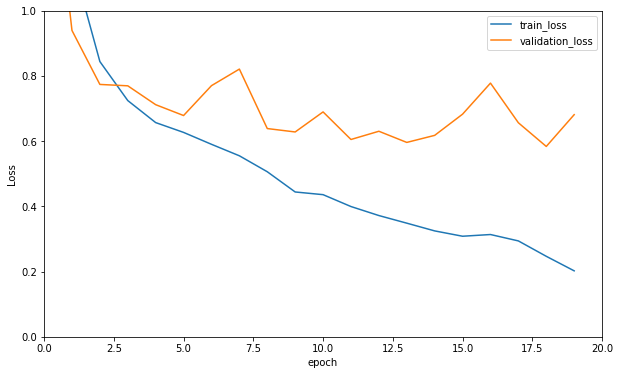

In [17]:
# PLOT Loss
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_loss_list, label='train_loss')
ax.plot(val_loss_list, label='validation_loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
plt.xlim([0, 20])
plt.ylim([0, 1])

In [20]:
net.eval()
total_examples = 0
correct_examples = 0
    

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      x, y = inputs.to(device), targets.to(device)
      y_pred = net(x)
      _, labels = torch.max(y_pred, 1)  
      
      correct_examples += (labels == y).float().sum()
      total_examples += len(inputs)

    avg_acc = correct_examples / total_examples
    print("Testing accuracy: %.4f" % (avg_acc))

Testing accuracy: 0.8611
